In [25]:
#import libraries
import pandas as pd
import pymongo
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy import text
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Create Connection to postgres

In [26]:
conn = psycopg2.connect(database="postgres", user='postgres', password='postgres', host='127.0.0.1', port='5432')
conn.autocommit = True

### Create Database in postgres

In [27]:
cursor = conn.cursor()

sql = '''CREATE database beer_db''';

cursor.execute(sql)
print("Database created successfully........")

#Closing the connection
conn.close()

Database created successfully........


## Store CSV into DataFrame

In [28]:
#create beers dataframe from csv
csv_file = "../ETL-Project/data/archive/beers.csv"
beers_df = pd.read_csv(csv_file)
beers_df.head()

,Unnamed: 0,abv,ibu,id,name,style,brewery_id,ounces
0,0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0
3,3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0
4,4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0


In [29]:
#create breweries dataframe from csv
csv_file = "../ETL-Project/data/archive/breweries.csv"
breweries_df = pd.read_csv(csv_file)
breweries_df.head()

,Unnamed: 0,name,city,state
0,0,NorthGate Brewing,Minneapolis,MN
1,1,Against the Grain Brewery,Louisville,KY
2,2,Jack's Abby Craft Lagers,Framingham,MA
3,3,Mike Hess Brewing Company,San Diego,CA
4,4,Fort Point Beer Company,San Francisco,CA


In [30]:
#rename unnamed columns, id, and name
breweries_df.rename(columns = {'Unnamed: 0':'brewery_id', 'name':'brewery_name'}, inplace = True) 
breweries_df.head()


,brewery_id,brewery_name,city,state
0,0,NorthGate Brewing,Minneapolis,MN
1,1,Against the Grain Brewery,Louisville,KY
2,2,Jack's Abby Craft Lagers,Framingham,MA
3,3,Mike Hess Brewing Company,San Diego,CA
4,4,Fort Point Beer Company,San Francisco,CA


In [31]:
#set brewery_id as index
breweries_df.set_index("brewery_id")

,brewery_name,city,state
brewery_id,,,
0,NorthGate Brewing,Minneapolis,MN
1,Against the Grain Brewery,Louisville,KY
2,Jack's Abby Craft Lagers,Framingham,MA
3,Mike Hess Brewing Company,San Diego,CA
4,Fort Point Beer Company,San Francisco,CA
...,...,...,...
553,Covington Brewhouse,Covington,LA
554,Dave's Brewfarm,Wilson,WI
555,Ukiah Brewing Company,Ukiah,CA


In [32]:
#remove space character before each state name to prevent any issues with postgreSQL later
breweries_df.state = breweries_df.state.str.lstrip()
breweries_df

,brewery_id,brewery_name,city,state
0,0,NorthGate Brewing,Minneapolis,MN
1,1,Against the Grain Brewery,Louisville,KY
2,2,Jack's Abby Craft Lagers,Framingham,MA
3,3,Mike Hess Brewing Company,San Diego,CA
4,4,Fort Point Beer Company,San Francisco,CA
...,...,...,...,...
553,553,Covington Brewhouse,Covington,LA
554,554,Dave's Brewfarm,Wilson,WI
555,555,Ukiah Brewing Company,Ukiah,CA
556,556,Butternuts Beer and Ale,Garrattsville,NY


In [33]:
#drop columns in beer_df
beers_df = beers_df.drop(columns=['Unnamed: 0', 'ibu'])
#beers_df.head()

In [34]:
#rename id and name columns in beers_df
beers_df.rename(columns = {'id':'beer_id', 'name':'beer_name'}, inplace = True) 

In [35]:
#set beer_id as index
beers_df.set_index("beer_id")

,abv,beer_name,style,brewery_id,ounces
beer_id,,,,,
1436,0.050,Pub Beer,American Pale Lager,408,12.0
2265,0.066,Devil's Cup,American Pale Ale (APA),177,12.0
2264,0.071,Rise of the Phoenix,American IPA,177,12.0
2263,0.090,Sinister,American Double / Imperial IPA,177,12.0
2262,0.075,Sex and Candy,American IPA,177,12.0
...,...,...,...,...,...
928,0.067,Belgorado,Belgian IPA,424,12.0
807,0.052,Rail Yard Ale,American Amber / Red Ale,424,12.0
620,0.055,B3K Black Lager,Schwarzbier,424,12.0


## Build Schema in SQL

In [44]:
conn = psycopg2.connect(database="beer_db", user='postgres', password='postgres', host='127.0.0.1', port='5432')
conn.autocommit = True
cursor = conn.cursor()

In [45]:
schema_sql = open('Schema Build.sql','r')
cursor.execute(schema_sql.read())

DuplicateTable: relation "brewery" already exists


## Create connection for Load operation

In [38]:
connection_string = "postgres:postgres@localhost:5432/beer_db"
engine = create_engine(f'postgresql://{connection_string}')

In [39]:
# Confirm tables
engine.table_names()

['brewery', 'beers']

### Load the DF into Postgres

In [40]:
breweries_df.to_sql(name='brewery', con=engine, if_exists='append', index=False)

In [41]:
beers_df.to_sql(name='beers', con=engine, if_exists='append', index=False)

### Dispose of the Connection to the Database

In [42]:
engine.dispose()

In [46]:
sql = conn.cursor()

In [47]:
sql.execute("SELECT bw.brewery_name, bw.state, br.beer_name FROM BEERS br INNER JOIN BREWERY bw ON br.BREWERY_ID = bw.BREWERY_ID ORDER BY bw.state ASC;")
result_data = sql.fetchall()

print(result_data)

), ('Deep Ellum Brewing Company', 'TX', 'Dream Crusher Double IPA'), ('Deep Ellum Brewing Company', 'TX', 'Deep Ellum Pale Ale'), ('Deep Ellum Brewing Company', 'TX', 'Double Brown Stout'), ('Martin House Brewing Company', 'TX', 'Day Break 4-Grain Breakfast Beer'), ('Martin House Brewing Company', 'TX', 'River House Saison'), ('Pedernales Brewing Company', 'TX', 'Robert Earl Keen Honey Pils'), ('Pedernales Brewing Company', 'TX', 'Lobo Lito'), ('Armadillo Ale Works', 'TX', 'Quakertown Stout'), ('Texian Brewing Co.', 'TX', 'Battle LIne'), ('Karbach Brewing Company', 'TX', 'Weisse Versa (2012)'), ('Karbach Brewing Company', 'TX', 'Mother in Lager'), ('Martin House Brewing Company', 'TX', 'There Will Be Stout'), ('Deep Ellum Brewing Company', 'TX', 'Farmhouse Wit'), ('Deep Ellum Brewing Company', 'TX', 'Rye Pils Session Lager'), ('Karbach Brewing Company', 'TX', 'Weekend Warrior Pale Ale'), ('Karbach Brewing Company', 'TX', 'Karbachtoberfest'), ('Karbach Brewing Company', 'TX', 'Love Stre

In [48]:
col_names = []
for c in sql.description:
    col_names.append(c[0])

In [49]:
brewery_and_state_df = pd.DataFrame(result_data, columns=(col_names))
brewery_and_state_df

,brewery_name,state,beer_name
0,King Street Brewing Company,AK,King Street IPA
1,Kenai River Brewing Company,AK,Skilak Scottish Ale
2,Broken Tooth Brewing Company,AK,Fairweather IPA
3,Broken Tooth Brewing Company,AK,Chugach Session Ale
4,Broken Tooth Brewing Company,AK,Polar Pale Ale
...,...,...,...
2405,Wind River Brewing Company,WY,Wind River Blonde Ale
2406,Snake River Brewing Company,WY,Monarch Pilsner
2407,Snake River Brewing Company,WY,Snow King Pale Ale
2408,Snake River Brewing Company,WY,Zonker Stout


In [58]:
sql.execute("SELECT br.style, br.abv, br.brewery_id FROM BEERS br ORDER BY br.style ASC;")
result_data = sql.fetchall()

print(result_data)

'English Pale Mild Ale', 0.045, 437), ('English Stout', 0.08, 165), ('English Stout', None, 132), ('English Strong Ale', 0.072, 336), ('English Strong Ale', 0.085, 368), ('English Strong Ale', 0.09, 27), ('English Strong Ale', 0.08, 460), ('Euro Dark Lager', 0.057, 165), ('Euro Dark Lager', 0.056, 82), ('Euro Dark Lager', 0.042, 390), ('Euro Dark Lager', 0.051, 116), ('Euro Dark Lager', 0.057, 342), ('Euro Pale Lager', 0.053, 382), ('Euro Pale Lager', 0.06, 127), ('Extra Special / Strong Bitter (ESB)', 0.048, 107), ('Extra Special / Strong Bitter (ESB)', 0.057, 352), ('Extra Special / Strong Bitter (ESB)', 0.061, 139), ('Extra Special / Strong Bitter (ESB)', 0.053, 58), ('Extra Special / Strong Bitter (ESB)', None, 531), ('Extra Special / Strong Bitter (ESB)', 0.072, 45), ('Extra Special / Strong Bitter (ESB)', 0.065, 382), ('Extra Special / Strong Bitter (ESB)', 0.057, 264), ('Extra Special / Strong Bitter (ESB)', 0.056, 380), ('Extra Special / Strong Bitter (ESB)', 0.056, 380), ('Ext

In [59]:
col_names = []
for c in sql.description:
    col_names.append(c[0])
  

In [66]:
beer_styles_df = pd.DataFrame(result_data, columns=(col_names))

# drop NaN from df
beer_styles_df = beer_styles_df.dropna(how='any')

#check to see if there are style names as 'none'
beer_styles_df.loc[beer_styles_df['style'] == 'None']
#result shows there are no rows with 'None' under style column
#beer_styles_df

,style,abv,brewery_id


## Bewery Count by State Bar Graph

In [54]:
brewery_state_count_df= brewery_and_state_df['state'].value_counts()
brewery_state_count_df.head(10)

CO    265
CA    183
MI    162
IN    139
TX    130
OR    125
PA    100
IL     91
WI     87
MA     82
Name: state, dtype: int64

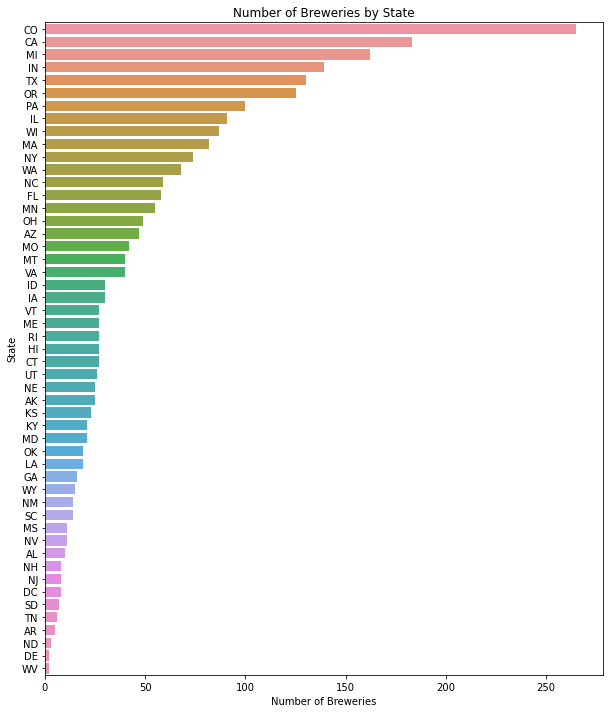

In [55]:
plt.figure(figsize=(10,12))
sns.barplot(y=brewery_state_count_df.index, x=brewery_state_count_df.values)
plt.title('Number of Breweries by State')
plt.xlabel('Number of Breweries')
plt.ylabel('State')
plt.yticks(rotation='horizontal')
plt.show()

## Most Popular Beer Style Bar Graph

In [56]:
beer_styles_count_df= beer_styles_df['style'].value_counts()

beer_styles_count_df.head(10)

American IPA                      424
American Pale Ale (APA)           245
American Amber / Red Ale          133
American Blonde Ale               108
American Double / Imperial IPA    105
American Pale Wheat Ale            97
American Brown Ale                 70
American Porter                    68
Saison / Farmhouse Ale             52
Witbier                            51
Name: style, dtype: int64

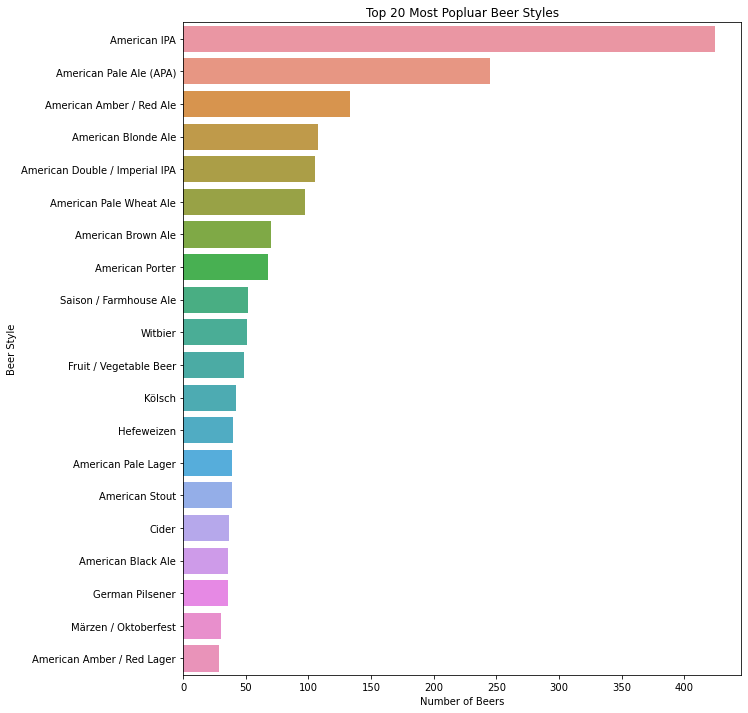

In [57]:
plt.figure(figsize=(10,12))
sns.barplot(y=beer_styles_count_df.nlargest(20).index, x=beer_styles_count_df.nlargest(20).values)
plt.title('Top 20 Most Popluar Beer Styles')
plt.xlabel('Number of Beers')
plt.ylabel('Beer Style')
plt.yticks(rotation='horizontal')
plt.show()

In [68]:
conn.close()